In [1]:
import itertools
import pickle

import torch
from leela_interp import Lc0sight, LeelaBoard
from leela_interp.tools.attention import attention_attribution, top_k_attributions
from leela_interp.tools.patching import activation_patch

/media/victor/F8D25071D25035DA/Alingment/lela-interp/neelaplicationexperiment/leela-interp/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pickle
import random
from pathlib import Path

import chess
import iceberg as ice
import matplotlib.pyplot as plt
import numpy as np
import torch
from leela_interp import Lc0Model, Lc0sight, LeelaBoard
from leela_interp.core.iceberg_board import palette
from leela_interp.tools import figure_helpers as fh
from leela_interp.tools.piece_movement_heads import (
    bishop_heads,
    knight_heads,
    rook_heads,
)

In [3]:
%ls

act_patching.ipynb*              other_figures.ipynb*
cornerablation.ipynb*            puzzle_example.ipynb*
demo.ipynb*                      Test_simple_puzzzle.ipynb*
figure_1.ipynb*                  website.ipynb*
neelaplicationexperiment.ipynb*


/media/victor/F8D25071D25035DA/Alingment/lela-interp/neelaplicationexperiment/leela-interp


/media/victor/F8D25071D25035DA/Alingment/lela-interp/neelaplicationexperiment/leela-interp/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i} ({torch.cuda.get_device_name(i)})")
        print(f"Memory allocated: {torch.cuda.memory_allocated(i) / 1e9:.2f} GB")
        print(f"Memory cached: {torch.cuda.memory_reserved(i) / 1e9:.2f} GB")

GPU 0 (NVIDIA GeForce GTX 1060)
Memory allocated: 0.00 GB
Memory cached: 0.00 GB


First, we load a dataset of puzzles selected to be challenging but solvable for Leela:

In [7]:
with open("interesting_puzzles.pkl", "rb") as f:
    puzzles = pickle.load(f)
len(puzzles)

22517

Let's look at one of these puzzles:

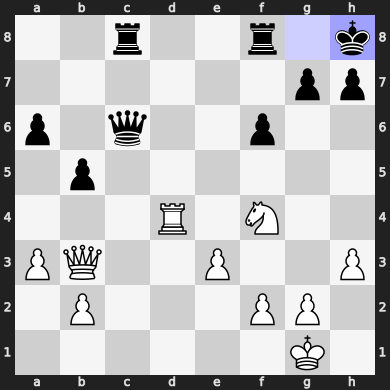

In [8]:
# This is the running example from the paper, you can pick a different one:
puzzle = puzzles.iloc[483]
# LeelaBoard instances can also be created from FENs or in other ways, but always
# use from_puzzle if you want to create one from a puzzle from the lichess dataset.
board = LeelaBoard.from_puzzle(puzzle)
board

The *principal variation* is the best sequence of moves for both sides:

In [9]:
puzzle.principal_variation

['f4g6', 'h7g6', 'd4h4']

Leela solves this puzzle correctly:

In [11]:
#model.pretty_play(board)

In [10]:
SETTING_TO_PRETTY_NAME = {
    "main": "Probe on trained model",
    "random_model": "Probe on random model",
}


def plot_probe_results(split="all",title="Third move prediction",nseeds=5):
    fh.set(fast=False)
    plt.figure(figsize=(fh.HALF_WIDTH, 2))

    for i, setting in enumerate(["main", "random_model"]):
        results = np.zeros((15, 5))
        for seed in range(nseeds):
            with open(f"results/probing/{split}/{seed}/{setting}.pkl", "rb") as f:
                new_results = pickle.load(f)
                results[:, seed] = new_results["accuracies"]

        means = results.mean(1)
        squared_seed_errors = results.var(1) / results.shape[1]
        # Size of the eval dataset is 30% of all puzzles
        squared_acc_errors = means * (1 - means) / (0.3 * len(puzzles))
        # 2 sigma errors
        errors = 2 * np.sqrt(squared_seed_errors + squared_acc_errors)

        max_layer = means.argmax()

        print(
            f"Max accuracy ({setting}, L{max_layer}): {means[max_layer]:.2f} +- {errors[max_layer]:.2f}"
        )
        plt.plot(
            means,
            label=SETTING_TO_PRETTY_NAME[setting],
            color=fh.COLORS[i],
            linewidth=fh.LINE_WIDTH,
        )
        plt.fill_between(
            range(15),
            means - errors,
            means + errors,
            color=fh.COLORS[i],
            alpha=fh.ERROR_ALPHA,
            linewidth=0,
        )

    plt.title(title)
    plt.xlabel("Layer")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.ylim(0, 1.0)
    plt.xlim(0, 14)
    plt.gca().spines[:].set_visible(False)
    plt.gca().set_facecolor(fh.PLOT_FACE_COLOR)
    plt.grid(linestyle="--")
    plt.grid(which="minor", alpha=0.3, linestyle="--")

In [13]:
#!python scripts/make_puzzles.py 

In [33]:
!python scripts/probing.py --random --n_seeds 5 --n_puzzles 500 

Using 500 puzzles total, 350 for training.
Using device: cuda
100%|█████████████████████████████████████████████| 1/1 [00:55<00:00, 55.02s/it]
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
100%|███████████████████████████████████████████| 15/15 [00:03<00:00,  3.78it/s]
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
100%|███████████████████████████████████████████| 15/15 [00:02<00:00,  5.17it/s]
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 

In [34]:
!python scripts/probing.py --main  --n_seeds 5 --n_puzzles 500

Using 500 puzzles total, 350 for training.
Using device: cuda
100%|█████████████████████████████████████████████| 1/1 [00:44<00:00, 44.97s/it]
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.28it/s]
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
100%|███████████████████████████████████████████| 15/15 [00:02<00:00,  5.08it/s]
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 

Max accuracy (main, L11): 0.76 +- 0.02
Max accuracy (random_model, L2): 0.07 +- 0.02


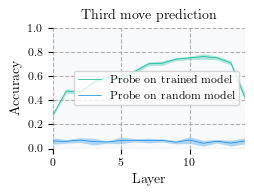

In [43]:
plot_probe_results()
fh.save("figures/probing.pdf")

In [ ]:
!python scripts/probing.py --random  --n_seeds 5 --n_puzzles 500 --puzzle_file "five_moves_puzzles.pkl" 

In [38]:
!python scripts/probing.py --main  --n_seeds 5 --n_puzzles 500 --puzzle_file "five_moves_puzzles.pkl"

Using 500 puzzles total, 350 for training.
Using device: cuda
100%|█████████████████████████████████████████████| 1/1 [00:49<00:00, 49.54s/it]
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
100%|███████████████████████████████████████████| 15/15 [00:17<00:00,  1.15s/it]
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
100%|███████████████████████████████████████████| 15/15 [00:02<00:00,  5.32it/s]
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 

Max accuracy (main, L11): 0.76 +- 0.02
Max accuracy (random_model, L2): 0.07 +- 0.02


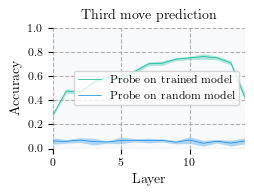

In [41]:
plot_probe_results()
fh.save("figures/probing.pdf")

In [55]:
!python scripts/probing.py --main  --n_seeds 5 --n_puzzles 500 --puzzle_file "five_moves_puzzles.pkl" --split "different_targets"

Using 70 puzzles total, 49 for training.
Using device: cuda
  0%|                                                     | 0/1 [00:02<?, ?it/s]
Traceback (most recent call last):
  File "/media/victor/F8D25071D25035DA/Alingment/lela-interp/neelaplicationexperiment/leela-interp/scripts/probing.py", line 309, in <module>
    main(args)
  File "/media/victor/F8D25071D25035DA/Alingment/lela-interp/neelaplicationexperiment/leela-interp/scripts/probing.py", line 222, in main
    activations = ActivationCache.capture(
  File "/media/victor/F8D25071D25035DA/Alingment/lela-interp/leela-interp/src/leela_interp/tools/activations.py", line 158, in capture
    data[name] = zarr.empty(
  File "/media/victor/F8D25071D25035DA/Alingment/lela-interp/neelaplicationexperiment/leela-interp/.venv/lib/python3.10/site-packages/zarr/hierarchy.py", line 514, in __setitem__
    self.array(item, value, overwrite=True)
  File "/media/victor/F8D25071D25035DA/Alingment/lela-interp/neelaplicationexperiment/leela-interp/

In [50]:
!python scripts/probing.py --random_model  --n_seeds 5 --n_puzzles 10000 --puzzle_file "five_moves_puzzles.pkl" --split "different_targets"

Using 70 puzzles total, 49 for training.
Using device: cuda
100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.83s/it]
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 22.10it/s]
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 19.77it/s]
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8


In [ ]:
!python scripts/probing.py --main  --n_seeds 5 --n_puzzles 500  --puzzle_file "five_moves_puzzles.pkl" --split "same_targets"

Using 500 puzzles total, 350 for training.
Using device: cuda
100%|█████████████████████████████████████████████| 1/1 [00:39<00:00, 39.44s/it]
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
100%|███████████████████████████████████████████| 15/15 [00:03<00:00,  3.85it/s]
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
100%|███████████████████████████████████████████| 15/15 [00:03<00:00,  4.83it/s]
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 

In [51]:
!python scripts/probing.py --random_model  --n_seeds 5 --n_puzzles 500  --puzzle_file "five_moves_puzzles.pkl" --split "same_targets"

Using 500 puzzles total, 350 for training.
Using device: cuda
100%|█████████████████████████████████████████████| 1/1 [00:50<00:00, 50.07s/it]
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.25it/s]
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
100%|███████████████████████████████████████████| 15/15 [00:03<00:00,  4.81it/s]
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 

In [314]:
!python scripts/probing.py --main  --n_seeds 5 --n_puzzles 500  --puzzle_file "five_moves_puzzles.pkl" --random_z

Traceback (most recent call last):
  File "/media/victor/F8D25071D25035DA/Alingment/lela-interp/neelaplicationexperiment/leela-interp/scripts/probing.py", line 307, in <module>
    parser.add_argument("--random_z", default="all", type="store_true")
  File "/usr/lib/python3.10/argparse.py", line 1447, in add_argument
    raise ValueError('%r is not callable' % (type_func,))
ValueError: 'store_true' is not callable


In [18]:
!python scripts/probing.py --random  --n_seeds 5 --n_puzzles 500  --puzzle_file "five_moves_puzzles.pkl" --rand_z
!python scripts/probing.py --main  --n_seeds 5 --n_puzzles 500  --puzzle_file "five_moves_puzzles.pkl" --rand_z

Using 500 puzzles total, 350 for training.
Using device: cuda
100%|█████████████████████████████████████████████| 1/1 [00:49<00:00, 49.30s/it]
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.36it/s]
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
100%|███████████████████████████████████████████| 15/15 [00:03<00:00,  4.57it/s]
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 

Max accuracy (main, L12): 0.45 +- 0.02
Max accuracy (random_model, L3): 0.03 +- 0.01


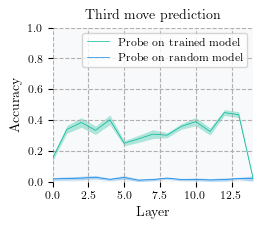

In [19]:
plot_probe_results()

In [16]:
!python scripts/probing.py --random  --n_seeds 5 --n_puzzles 500  --rand_z
!python scripts/probing.py --main  --n_seeds 5 --n_puzzles 500  --rand_z

Using 500 puzzles total, 350 for training.
Using device: cuda
100%|█████████████████████████████████████████████| 1/1 [00:44<00:00, 44.23s/it]
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
100%|███████████████████████████████████████████| 15/15 [00:10<00:00,  1.40it/s]
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
100%|███████████████████████████████████████████| 15/15 [00:03<00:00,  4.87it/s]
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 

Max accuracy (main, L13): 0.45 +- 0.03
Max accuracy (random_model, L11): 0.02 +- 0.01


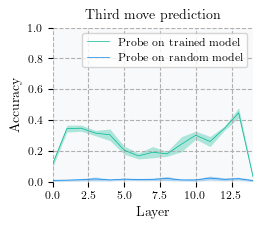

In [17]:
plot_probe_results()

In [4]:
!python scripts/probing.py --random  --n_seeds 5 --n_puzzles 500   --rand_z
!python scripts/probing.py --main  --n_seeds 5 --n_puzzles 500  --rand_z

Using 500 puzzles total, 350 for training.
Using device: cuda
100%|█████████████████████████████████████████████| 1/1 [01:12<00:00, 72.96s/it]
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.61it/s]
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
100%|███████████████████████████████████████████| 15/15 [00:02<00:00,  5.25it/s]
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 

Max accuracy (main, L13): 0.47 +- 0.03
Max accuracy (random_model, L5): 0.03 +- 0.01


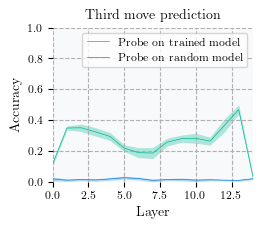

In [12]:
plot_probe_results()

In [57]:
with open("results/probing/all/0/target_probes.pkl", "rb") as f:
    target_probes = pickle.load(f)

In [60]:
len(target_probes)

15

In [63]:
target_probes[10].W_x.shape

torch.Size([32, 768])

In [64]:
target_probes[10].W_z.shape

torch.Size([32, 768])

In [67]:
import zarr

In [71]:
z = zarr.open("./residual_activations.zarr",mode="r")

In [11]:
from leela_interp import ActivationCache, Lc0Model, LeelaBoard

In [83]:
model = Lc0sight("lc0.onnx", device=device)

Using device: cuda


In [84]:
puzzle_file="./five_moves_puzzles.pkl"
n_puzzles=10

In [225]:
try:
    with open( puzzle_file, "rb") as f:
        puzzles = pickle.load(f)
except FileNotFoundError:
    raise ValueError("Puzzles not found, run make_puzzles.py first")
if n_puzzles > 0:
    puzzles = puzzles.iloc[: n_puzzles]

In [176]:
activations = ActivationCache.capture(
        model=model,
        boards=[LeelaBoard.from_puzzle(p) for _, p in puzzles.iterrows()],
        # There's a typo in Lc0, so we mirror it; "rehape" is deliberate
        names=["attn_body/ma_gating/rehape2"]
        + [f"encoder{layer}/ln2" for layer in range(15)],
        n_samples=len(puzzles),
        # Uncomment to store activations on disk (they're about 70GB).
        # Without a path, they'll be kept in memory, which is faster but uses 70GB of RAM.
        path="residual_activations_generateTest.zarr",
        overwrite=False,
        )

FileExistsError: File residual_activations_generateTest.zarr already exists

In [283]:
puzle_number=1

In [286]:
z = puzzles.iloc[puzle_number].principal_variation[0][2:4]#  first move target
z_square=board.sq2idx(z)
y = puzzles.iloc[puzle_number].principal_variation[2][2:4]#third move target
y_square=board.sq2idx(y)
X = activations[f"encoder{10}/ln2"][puzle_number:puzle_number+1]
Z = X[np.arange(len(X)), [z_square], :]
assert Z.shape == (len(X), 768)
target_squares = target_probes[10].predict(X, Z)

In [287]:
target_probes[10].predict(X,Z)

array([44])

In [279]:
target_probes[10].predict_proba(X,Z)[0,y_square]

1.0

In [280]:
y_square

17

In [288]:
puzle_number=1

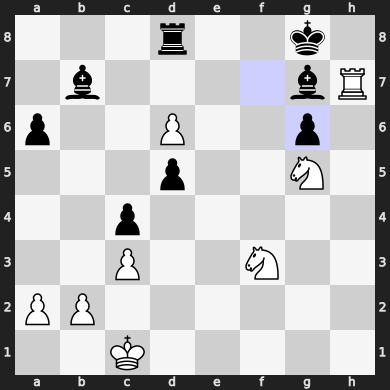

In [297]:
board.from_puzzle(puzzles.iloc[puzle_number])

In [298]:
with model.trace(board.from_puzzle(puzzles.iloc[puzle_number])):
    residual_stream = model.residual_stream(10).output.save()
residual_stream.shape

torch.Size([1, 64, 768])

In [304]:
z = puzzles.iloc[puzle_number].principal_variation[0][2:4]#  first move target
z_square=board.sq2idx(z)
y = puzzles.iloc[puzle_number].principal_variation[2][2:4]#third move target
y_square=board.sq2idx(y)

In [306]:
X = residual_stream
Z = X[np.arange(len(X)), [z_square], :]
assert Z.shape == (len(X), 768)
target_squares = target_probes[10].predict(X, Z)

In [307]:
target_probes[10].predict_proba(X,Z)[0,y_square]

1.0